In [18]:
from ktms import *
from MAInit import *
from MACalc import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
dictlis = [{'element':'Cu', 'mirror':'100', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Cu', 'mirror':'111', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'100', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Ag', 'mirror':'111', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'100', 'moved+':'no', 'moved':'no', 'unitlength':2},
           {'element':'Pt', 'mirror':'111', 'moved+':'no', 'moved':'no', 'unitlength':2},
#            {'element':'NiGa', 'mirror':'110', 'moved+':'no', 'moved':'no'},
#            {'element':'CoPt3', 'mirror':'100', 'moved+':'no', 'moved':'no'},
           {'element':'Pd', 'mirror':'100', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Pd', 'mirror':'111', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Au', 'mirror':'100', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Au', 'mirror':'111', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Al', 'mirror':'100', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Al', 'mirror':'111', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Ni', 'mirror':'100', 'moved+':'no', 'moved':'no', 'unitlength':2},           
           {'element':'Ni', 'mirror':'111', 'moved+':'no', 'moved':'no', 'unitlength':2},           
          ]

In [5]:
results = []
for dic in dictlis:
    tmp = []
    for post in collection.find(dic):
        tmp.append(post)
    results.append(tmp)

df = []
dfpred = []

for i in range(len(results)):
    df.append(pd.DataFrame(results[i]))
    dfpred.append(df[i][df[i]['numberofads'] > 1])

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]
    
### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsEne/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
covset

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.

[[0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0],
 [0.5, 0.75, 1.0]]

### Predict ####

In [8]:
def predE(df):
    name = df['name']
    res = re.match('(.*u\d).*', name)
    barefile = res.group(1) + '.traj'
    bareatoms = query(barefile, 'spacom')
    slabE = bareatoms.get_potential_energy()
    
    igroups = df['igroups']
    adsElis = [] # adsE + slabE
    
    for i in range(len(igroups)):
        tmp = []
        tmp.append(igroups[i])
        se = {'element':df['element'], 'mirror':df['mirror'], 'unitlength':int(df['unitlength']), 'igroups':tmp}
        adsE = collection.find_one(se)['Ediff']
        adsElis.append(adsE)
    
    predene = (1 - len(adsElis))*slabE + sum(adsElis) + df['ECO_Eint']
    predtotaladsene = predene - (df['Energy'] - df['totaladsEnergy'])
    predadsene_surf = predtotaladsene/df['surfatomnum']
    
    return predadsene_surf

In [9]:
# predElis = []
# for i in range(len(dfpred)):
#     tmp = []
#     for j in range(len(dfpred[i])):
#         tmp.append(predE(dfpred[i].iloc[j]))
#     predElis.append(tmp)

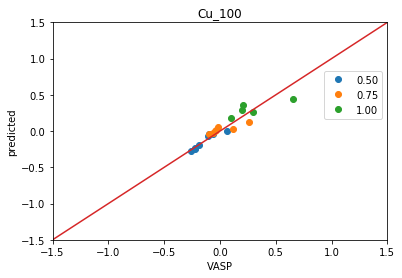

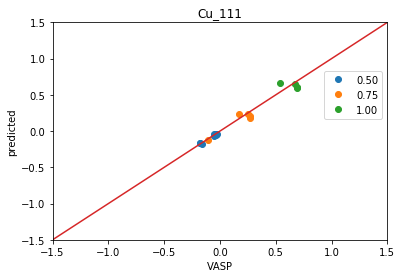

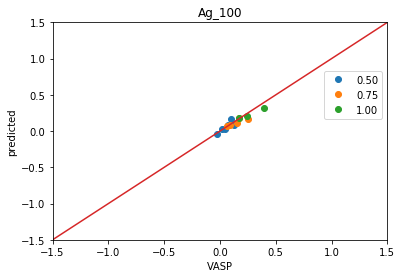

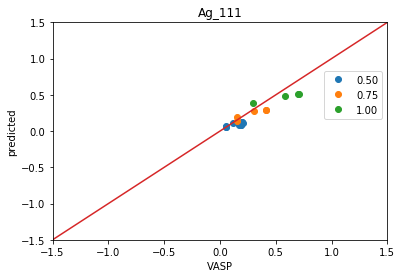

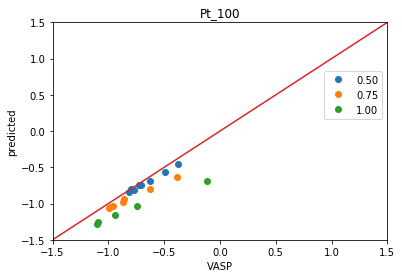

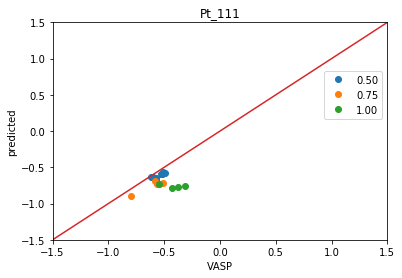

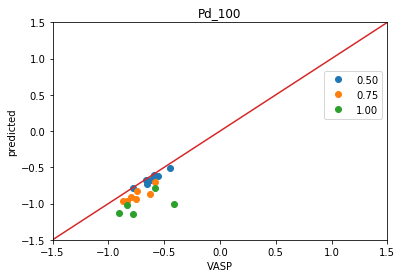

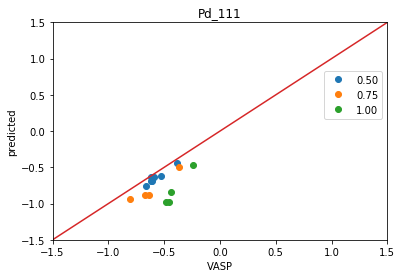

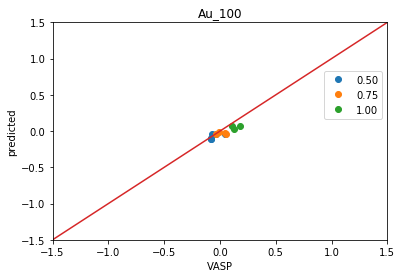

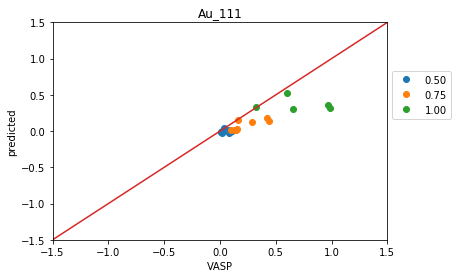

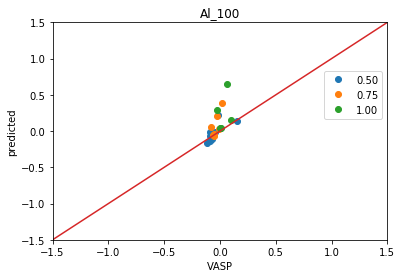

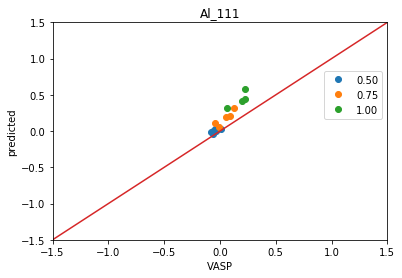

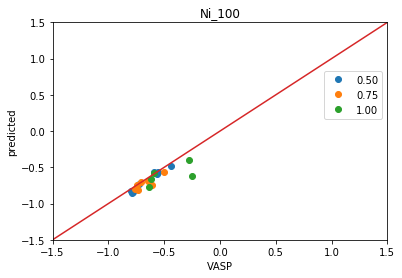

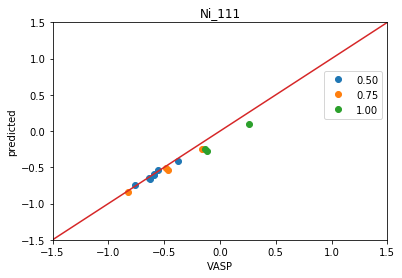

In [10]:
xrange = np.linspace(-2, 2)
for i in range(len(dfpred)):
    xmin = 100
    xmax = -100
    dfpred[i]['predE/surfatom'] = 0
    for j in range(len(dfpred[i])):
        dfpred[i].iloc[j, -1] = predE(dfpred[i].iloc[j])    
    for j in range(len(covset[i])):
        predElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['predE/surfatom'])
        calcElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'])
        if calcElis == []:
            continue
        if xmin > np.min(calcElis):
            xmin = np.min(calcElis)
        if xmax < np.max(calcElis):
            xmax = np.max(calcElis)
        plt.plot(calcElis, predElis, 'o')
    plt.plot(xrange, xrange, '-')
#     plt.xlim(xmin-0.4, xmax+0.4)
#     plt.ylim(xmin-0.4, xmax+0.4)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    plt.xlabel('VASP')
    plt.ylabel('predicted')
#     plt.savefig('{}_{}_predE.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.show()

In [11]:
def predE_(df):
    name = df['name']
    res = re.match('(.*u\d).*', name)
    barefile = res.group(1) + '.traj'
    bareatoms = query(barefile, 'spacom')
    slabE = bareatoms.get_potential_energy()
    
    igroups = df['igroups']
    adsElis = [] # adsE + slabE
    COEdifflis = []
    a2 = 46.252
    a1 = -106.43
    a0 = 46.754
    def COene(COlen):
        return a2*COlen**2 + a1*COlen + a0
    
    for i in range(len(igroups)):
        tmp = []
        tmp.append(igroups[i])
        se = {'element':df['element'], 'mirror':df['mirror'], 'unitlength':int(df['unitlength']), 'igroups':tmp}
        adsE = collection.find_one(se)['Ediff']
        COlen = collection.find_one(se)['COlengthlis'][0]
        COEdiff = COene(COlen) - COene(1.148)
#         print(COEdiff)
        adsElis.append(adsE)
        COEdifflis.append(COEdiff)
#         print(COEdifflis)
    
    predene = (1 - len(adsElis))*slabE + sum(adsElis) + df['ECO_Eint'] + sum(COEdifflis)
    predtotaladsene = predene - (df['Energy'] - df['totaladsEnergy'])
    predadsene_surf = predtotaladsene/df['surfatomnum']
    
    return predadsene_surf

In [12]:
file = dfpred[5].iloc[14]
predE_(file)
file['COlengthlis']

[1.1840499631709267, 1.1843960381763299, 1.183937666499867, 1.1838644628979305]

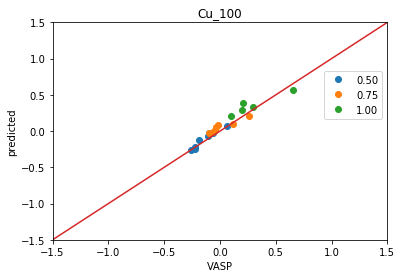

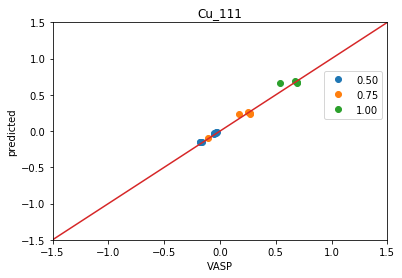

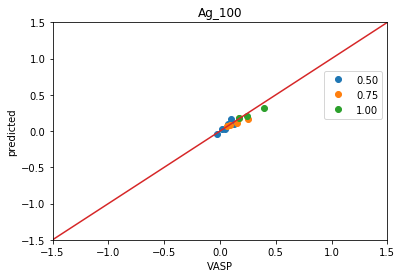

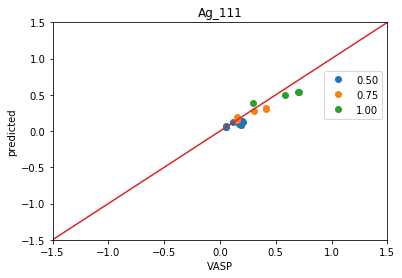

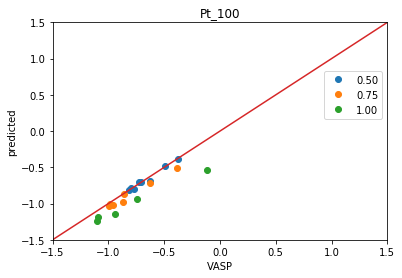

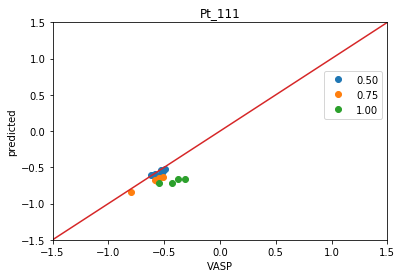

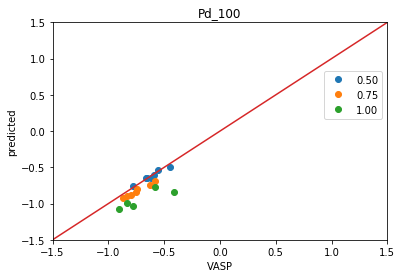

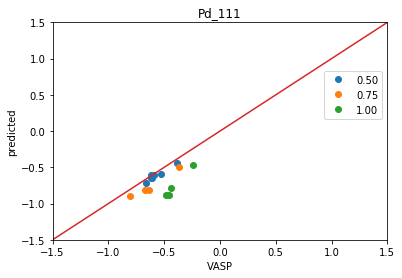

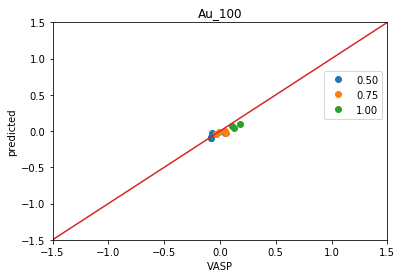

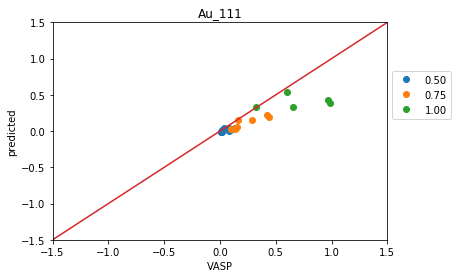

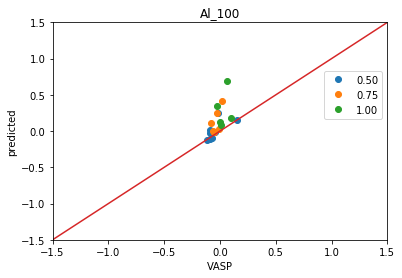

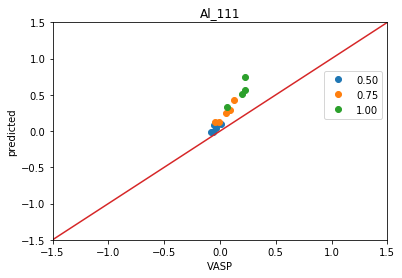

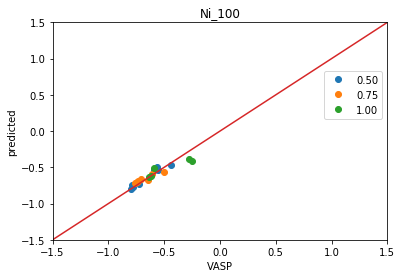

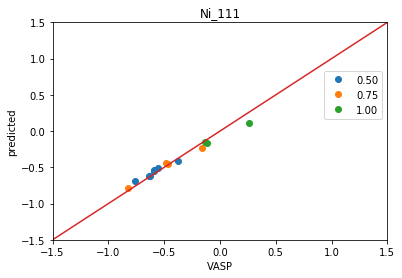

In [13]:
xrange = np.linspace(-2, 2)
for i in range(len(dfpred)):
    xmin = 100
    xmax = -100
    dfpred[i]['predE/surfatom'] = 0
    for j in range(len(dfpred[i])):
        dfpred[i].iloc[j, -1] = predE_(dfpred[i].iloc[j])    
    for j in range(len(covset[i])):
        predElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['predE/surfatom'])
        calcElis = list(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'])
        if calcElis == []:
            continue
        if xmin > np.min(calcElis):
            xmin = np.min(calcElis)
        if xmax < np.max(calcElis):
            xmax = np.max(calcElis)
        plt.plot(calcElis, predElis, 'o')
    plt.plot(xrange, xrange, '-')
#     plt.xlim(xmin-0.4, xmax+0.4)
#     plt.ylim(xmin-0.4, xmax+0.4)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    plt.xlabel('VASP')
    plt.ylabel('predicted')
    plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.show()

In [19]:
dfpred[5][dfpred[5]['numberofads']==4]

,_id,name,element,mirror,adsorbate,unitlength,surfatomnum,area,Energy,totaladsEnergy,aveadsEne/suratom,numberofads,coverage,density,igroups,iposlis,rgroups,rposlis,ECO_Eint,Ediff,COlengthlis,aveadsEne/ads,moved+,moved,predE/surfatom
4,5d7c0f0924fcd5b4cb7e3487,Pt_111_u2_no04_CO_n4_d3.traj,Pt,111,CO,2,4,27.585488,-143.060864,-2.198819,-0.549705,4,1.0,0.145004,"[0, 0, 0, 0]","[[4.232883176781282, 2.4438562415629113, 18.76...","[0, 0, 0, 0]","[[4.232902759871253, 2.443855820773753, 18.867...",-55.537657,-87.523207,"[1.1644804461017866, 1.1643755897134356, 1.164...",-0.549705,no,no,-0.717275
11,5d7c0f0f24fcd5b4cb7e348e,Pt_111_u2_no11_CO_n4_d3.traj,Pt,111,CO,2,4,27.585488,-142.571065,-1.709020,-0.427255,4,1.0,0.145004,"[1, 1, 1, 1]","[[4.938363706244827, 3.6657843623443673, 18.76...","[1, 1, 1, 1]","[[4.604266649020142, 3.858066789969858, 18.582...",-55.537657,-87.033409,"[1.1764732679826304, 1.17694693783762, 1.17646...",-0.427255,no,no,-0.722800
18,5d7c0f1424fcd5b4cb7e3495,Pt_111_u2_no18_CO_n4_d3.traj,Pt,111,CO,2,4,27.585488,-142.366908,-1.504863,-0.376216,4,1.0,0.145004,"[2, 2, 2, 2]","[[5.643844235708377, 3.258474988750548, 18.762...","[2, 2, 2, 2]","[[5.643765419877283, 3.2584162564342334, 18.46...",-55.536840,-86.830068,"[1.1840499631709267, 1.1843960381763299, 1.183...",-0.376216,no,no,-0.665566
23,5d7c0f1824fcd5b4cb7e349a,Pt_111_u2_no23_CO_n4_d3.traj,Pt,111,CO,2,4,27.585488,-142.112941,-1.250896,-0.312724,4,1.0,0.145004,"[3, 3, 3, 3]","[[7.054805294635473, 4.073093735938186, 18.762...","[3, 3, 3, 3]","[[7.054847757332894, 4.07306927925149, 18.5161...",-55.536845,-86.576096,"[1.1835445591840232, 1.1835057056914526, 1.183...",-0.312724,no,no,-0.654938


In [23]:
df[5][df[5]['numberofads']==0]

,_id,name,element,mirror,adsorbate,unitlength,surfatomnum,area,Energy,totaladsEnergy,aveadsEne/suratom,numberofads,coverage,density,igroups,iposlis,rgroups,rposlis,ECO_Eint,Ediff,COlengthlis,aveadsEne/ads,moved+,moved
0,5d7c0f0624fcd5b4cb7e3483,Pt_111_u2.traj,Pt,111,0,2,4,27.585488,-82.9203,0.0,0.0,0,0.0,0.0,[],[],[],[],0.0,-82.9203,[],NaN,no,no


In [24]:
df[5][df[5]['numberofads']==1]

,_id,name,element,mirror,adsorbate,unitlength,surfatomnum,area,Energy,totaladsEnergy,aveadsEne/suratom,numberofads,coverage,density,igroups,iposlis,rgroups,rposlis,ECO_Eint,Ediff,COlengthlis,aveadsEne/ads,moved+,moved
1,5d7c0f0724fcd5b4cb7e3484,Pt_111_u2_no01_CO_n1_d9.traj,Pt,111,CO,2,4,27.585488,-98.728217,-1.322481,-0.330620,1,0.25,0.036251,[0],"[[0.0, 0.0, 18.762269282616817]]",[0],"[[-2.4586243209140364e-06, -2.6513049185610634...",-14.482056,-84.246161,[1.1635841876803108],-1.322481,no,no
8,5d7c0f0c24fcd5b4cb7e348b,Pt_111_u2_no08_CO_n1_d9.traj,Pt,111,CO,2,4,27.585488,-98.788672,-1.382936,-0.345734,1,0.25,0.036251,[1],"[[0.7054805294635469, 1.2219281207814556, 18.7...",[1],"[[0.72402606853218, 1.2112380153831184, 18.528...",-14.482056,-84.306616,[1.1873911204943426],-1.382936,no,no
15,5d7c0f1224fcd5b4cb7e3492,Pt_111_u2_no15_CO_n1_d9.traj,Pt,111,CO,2,4,27.585488,-98.780969,-1.375233,-0.343808,1,0.25,0.036251,[2],"[[1.4109610589270938, 0.8146187471876369, 18.7...",[2],"[[1.4110867392994384, 0.8146905357266045, 18.3...",-14.481837,-84.299132,[1.1998281744615316],-1.375233,no,no
20,5d7c0f1624fcd5b4cb7e3497,Pt_111_u2_no20_CO_n1_d9.traj,Pt,111,CO,2,4,27.585488,-98.767131,-1.361395,-0.340349,1,0.25,0.036251,[3],"[[2.821922117854188, 1.6292374943752728, 18.76...",[3],"[[2.821762511444936, 1.6291451007662354, 18.36...",-14.481837,-84.285294,[1.1991193123948023],-1.361395,no,no


In [31]:
query('Pt_111_u2_no23_CO_n4_d3_all.traj', 'local')

Atoms(symbols='Pt16COCOCOCO', pbc=True, cell=[[5.64384424, 0.0, 0.0], [2.82192212, 4.88771248, 0.0], [0.0, 0.0, 26.91226928]], constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7]), calculator=SinglePointCalculator(...))